In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

#Drop & why
- connection_time                   Drop (88% zeros, low correlation)
-
#KEEP
- protocol
- service_type
- connection_status
- source_bytes
- destination_bytes
- suspicious_activity ----------------------------
- compromised_count
- guest_login
-

In [14]:
df = pd.read_csv("data/Project_Phase1.csv")

In [15]:
## Feature Engineering

X = df[list(set(df.columns) - {"class"})]
y = df["class"].replace({"normal":0, "anomaly":1})

# Numeric Features
X_numeric = df[[col for col in df.columns if df[col].dtype != "O"]]
numeric_feature_names = X_numeric.columns
X_numeric = X_numeric.to_numpy()

# All features
df_encoded = pd.get_dummies(X).replace({False:0, True:1})
feature_names = pd.Series(df_encoded.columns)
X = df_encoded.to_numpy()

X.shape

/tmp/ipykernel_8795/3478938297.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df["class"].replace({"normal":0, "anomaly":1})
/tmp/ipykernel_8795/3478938297.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = pd.get_dummies(X).replace({False:0, True:1})


(14036, 102)

In [16]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


alpha_values = np.arange(0, 1, 0.001)
f1_results = []
recall_results = []

for alpha in alpha_values:
  lasso = Lasso(alpha=alpha, random_state=42)
  lasso.fit(X_scaled, y)

  features = feature_names
  feature_importance = pd.DataFrame({
      'Feature': features,  # Your feature names
      'Coefficient': lasso.coef_
  })

  # Features with non-zero coefficients are selected
  selected_features = feature_importance[feature_importance['Coefficient'] != 0]

  if len(selected_features) == 0:
    break

  X_final = df_encoded[selected_features["Feature"]].to_numpy()

  X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.33, random_state=42)

  clf = LogisticRegression(random_state=0).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  f1_results.append(f1_score(y_test, y_pred))
  recall_results.append(recall_score(y_test, y_pred))

alpha_values = alpha_values[:len(f1_results)]
print(f"Selected {len(selected_features)} out of {len(features)} features")

print("\nSeleceted Features:")
print(selected_features.sort_values(by="Feature"))

/home/maro/.cache/pypoetry/virtualenvs/pred-sus-act-oHUzRMnF-py3.12/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/maro/.cache/pypoetry/virtualenvs/pred-sus-act-oHUzRMnF-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/maro/.cache/pypoetry/virtualenvs/pred-sus-act-oHUzRMnF-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.971e+01, tolerance: 5.625e-02 Linear regression models with null weight for the l1 re

Selected 0 out of 102 features

Seleceted Features:
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []


<Axes: >

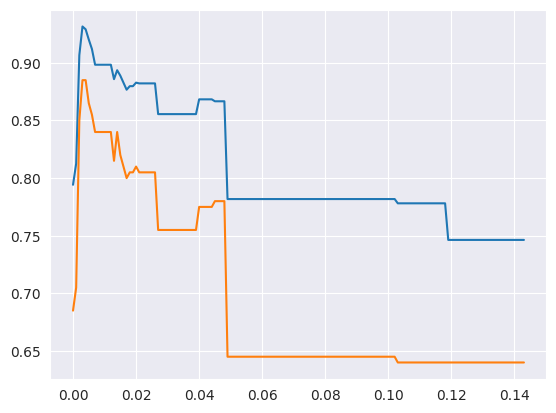

In [17]:
sns.lineplot(x=alpha_values, y=f1_results)
sns.lineplot(x=alpha_values, y=recall_results)

In [18]:
print("Best Alpha Value =", round(alpha_values[np.argsort(f1_results)[-1]], 10))
print("Included Numeric Features = ", 27 - len(set(numeric_feature_names) - set(selected_features["Feature"])))

Best Alpha Value = 0.003
Included Numeric Features =  0


In [19]:
lasso = Lasso(alpha=.003, random_state=42)
lasso.fit(X_scaled, y)

features = feature_names
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': lasso.coef_
})

# Features with non-zero coefficients are selected
selected_features = feature_importance[feature_importance['Coefficient'] != 0]
selected_features

,Feature,Coefficient
0,destination_different_server_rate,0.016259
2,destination_server_reset_error_rate,0.007095
4,different_server_rate,-0.018856
6,destination_host_count,0.000753
7,reset_error_rate,0.003045
...,...,...
91,connection_status_RSTO,0.004372
93,connection_status_RSTR,0.019803
94,connection_status_S0,0.023091
95,connection_status_S1,-0.005565


In [22]:
d = selected_features.set_index("Feature").T
d = d[selected_features["Feature"]].T.reset_index()
d["Coefficient"] = d["Coefficient"].apply(abs)
d.sort_values(by="Coefficient", ascending=False).reset_index(drop=True).head(20)

,Feature,Coefficient
0,same_server_rate,0.050823
1,destination_server_syn_error_rate,0.046699
2,connection_count,0.043212
3,service_type_private,0.025233
4,service_type_eco_i,0.023158
5,connection_status_S0,0.023091
6,protocol_udp,0.022467
7,server_syn_error_rate,0.019812
8,connection_status_RSTR,0.019803
9,different_server_rate,0.018856


In [25]:
f_names = list(d["Feature"])
filtered = df_encoded[ f_names ]
filtered['class']  = df['class']
filtered.to_csv("data/chosen_features.csv", index=False)
filtered

/tmp/ipykernel_8795/339471567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['class']  = df['class']


,destination_different_server_rate,destination_server_reset_error_rate,different_server_rate,destination_host_count,reset_error_rate,destination_host_server_count,same_server_rate,server_syn_error_rate,destination_same_source_port_rate,destination_same_server_rate,...,service_type_urp_i,service_type_uucp,service_type_uucp_path,service_type_vmnet,connection_status_RSTO,connection_status_RSTR,connection_status_S0,connection_status_S1,protocol_udp,class
0,0.00,0.01,0.00,87,0.0,87,1.00,0.00,0.01,1.00,...,0,0,0,0,0,0,0,0,0,anomaly
1,0.07,0.00,0.07,255,0.0,6,0.02,1.00,0.00,0.02,...,0,0,0,0,0,0,1,0,0,anomaly
2,0.08,0.00,0.06,255,0.0,12,0.07,1.00,0.00,0.05,...,0,0,0,0,0,0,1,0,0,anomaly
3,0.08,0.00,0.06,255,0.0,1,0.01,1.00,0.00,0.00,...,0,0,0,0,0,0,1,0,0,anomaly
4,0.07,0.00,0.06,255,0.0,11,0.09,1.00,0.00,0.04,...,0,0,0,0,0,0,1,0,0,anomaly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14031,0.07,0.00,0.00,58,0.0,27,1.00,0.00,0.12,0.12,...,0,0,0,0,0,0,0,0,0,normal
14032,0.00,0.00,0.00,255,0.0,255,1.00,0.00,0.00,1.00,...,0,0,0,0,0,0,0,0,0,normal
14033,0.02,0.10,0.00,255,0.0,60,1.00,0.00,0.00,0.24,...,0,0,0,0,0,0,0,0,0,normal
14034,0.17,0.00,0.00,12,0.0,11,1.00,0.00,0.08,0.92,...,0,0,0,0,0,0,0,0,0,normal
